# CMR Multi-Parameter Sweep

1. Setup
2. Simulation function
3. Analysis metrics
4. Visualization functions
5. Sweep function
6. Run sweeps (B_rec, gamma_fc, eta, B_encD_scale)

---
## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)


### List Configuration

In [2]:
# List length and presentation order
N = 10
pres_indices = np.random.permutation(N) + 1  # 1-indexed

# Sequence values (not used in basic CMR)
sequence = np.array([50, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45])

### Base Parameters

`BASE_PARAMS` contains defaults for all sweepable parameters.

In [3]:
# === Base Parameters (defaults when NOT sweeping) ===
BASE_PARAMS = {
    "B_rec": 0.55,              # Retrieval context drift
    "gamma_fc": 0.581,          # Pre-existing association strength
    "eta": 0.3699,              # Accumulator noise
    "B_encD_scale": 1.0,        # Encoding drift multiplier
}

# === Parameter Grids for Sweeping ===
B_rec_grid = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
gamma_fc_grid = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
eta_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
B_encD_scale_grid = [0.2, 0.4, 0.6, 0.8, 1.0]

BASE_SEED = 2026
n_sims = 1000


### Retrieval Route Weights

In [4]:
sem = 0
episodic = 1

sem_weight = sem / (episodic + sem)
episodic_weight = episodic / (episodic + sem)


### Context Drift & Semantic Matrix

In [5]:
# Encoding drift schedule
B_encD = np.array([1.0, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65])

# Semantic matrix (orthogonal item features)
sem_mat = np.eye(N)


### Fixed Parameters

In [6]:
# These remain constant across all sweeps
lrate_cf_enc = 1.0
lrate_fc_rec = 0.0
lrate_cf_rec = 0.0

# Accumulator dynamics
thresh = 1.0
rec_time = 90000  # ms
dt = 100          # ms
tau = 413         # ms
K = 0.091
L = 0.375

---
## Simulation Functions

### Single-trial runner

- Runs one complete encoding phase + retrieval phase.
- Builds the episodic weight matrices `net_w_fc`, `net_w_cf` from scratch each time (initialized using `gamma_fc_val` and then updated during encoding/retrieval).
- Applies the encoding drift schedule as:
    - `B_encD_local = B_encD * B_encD_scale`
    - then uses `B = B_encD_local[item_idx]` inside the encoding context update loop.
- Retrieval uses `B_rec` in the context update after each recalled item.

In [7]:
def simulate_single_trial(B_rec, rng, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0, record_diagnostics=False):
    """
    Simulate one encoding-retrieval trial.
    
    Parameters
    ----------
    B_rec : float
        Context drift rate during retrieval
    rng : numpy.random.Generator
        Random number generator
    gamma_fc_val : float, optional
        Pre-existing association strength (if None, uses global gamma_fc from BASE_PARAMS)
    eta_val : float, optional
        Accumulator noise (if None, uses global eta from BASE_PARAMS)
    B_encD_scale : float, optional
        Multiplier for encoding drift schedule
    record_diagnostics : bool
        Record cue advantage diagnostics
    
    Returns
    -------
    recalls, times, net_w_fc, net_w_cf, diagnostics
    """
    
    # Use provided values or BASE_PARAMS
    if gamma_fc_val is None:
        gamma_fc_val = BASE_PARAMS["gamma_fc"]
    if eta_val is None:
        eta_val = BASE_PARAMS["eta"]
    
    # derived params (recomputed if gamma_fc changes)
    eye_fc_local = 1.0 - gamma_fc_val
    eye_cf_local = 0.0
    lrate_fc_enc_local = gamma_fc_val
    
    # scale encoding drift
    B_encD_local = B_encD * B_encD_scale
    
    # ========== INITIALIZATION ==========
    net_f = np.zeros((N, 1))
    net_c = np.zeros((N, 1))
    
    # initialize weights with pre-existing associations
    net_w_fc = np.eye(N) * eye_fc_local
    net_w_cf = np.eye(N) * eye_cf_local
    
    # ========== ENCODING PHASE ==========
    for item_idx in range(N):
        feature_idx = pres_indices[item_idx] - 1
        
        net_f = np.zeros((N, 1))
        net_f[feature_idx] = 1
        
        # Context input through M_FC
        net_c_in = net_w_fc @ net_f
        net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
        
        # Context update
        c_in, c = net_c_in, net_c
        B = B_encD_local[item_idx]
        dot = float(c.T @ c_in)
        rho = np.sqrt(1 + (B**2) * ((dot**2) - 1)) - B * dot
        net_c = rho * c + B * c_in
        
        # Weight updates
        net_w_fc += (net_c @ net_f.T) * lrate_fc_enc_local
        net_w_cf += (net_f @ net_c.T) * lrate_cf_enc
    
    # ========== RETRIEVAL SETUP ==========
    recalls = np.zeros((N, 1))
    times = np.zeros((N, 1))
    retrieved = np.zeros((N, 1), dtype=bool)
    thresholds = np.ones((N, 1))
    
    net_weights = episodic_weight * net_w_cf + sem_weight * sem_mat
    
    time_passed = 0
    recall_count = 0
    
    # diagnostics
    if record_diagnostics:
        deltas_all = []
        deltas_by_pos = defaultdict(list)
        delta_forward = []
        delta_backward = []
        pending = None
    
    # ========== RETRIEVAL LOOP ==========
    while time_passed < rec_time:
        
        f_in = net_weights @ net_c
        
        max_cycles = int((rec_time - time_passed) / dt)
        dt_tau = dt / tau
        sq_dt_tau = np.sqrt(dt_tau)
        
        # pre-generate noise (use eta_val, not global eta)
        noise = rng.normal(0, eta_val * sq_dt_tau, size=(N, max_cycles))
        
        eyeI = ~np.eye(N, dtype=bool)
        lmat = eyeI.astype(float) * L
        
        x = np.zeros((N, 1))
        K_array = np.ones((N, 1)) * K
        inds = np.arange(N)
        
        crossed = 0
        i = 0
        
        while i < max_cycles and crossed == 0:
            
            lx = lmat @ x
            kx = K_array * x
            
            x = x + ((f_in - kx - lx) * dt_tau + noise[:, i:i+1])
            x[x < 0] = 0
            
            reset_these = retrieved & (x >= thresholds)
            x[reset_these] = 0.95 * thresholds[reset_these]
            
            retrievable = ~retrieved
            
            if np.any(x[retrievable] >= thresholds[retrievable]):
                crossed = 1
                temp_win = x[retrievable] >= thresholds[retrievable]
                temp_ind = inds[retrievable.flatten()]
                winners = temp_ind[temp_win.flatten()]
                
                if len(winners) > 1:
                    winners = np.array([rng.choice(winners)])
            
            i += 1
        
        time_passed += i * dt
        
        if crossed == 1:
            winner = int(winners[0])
            serial_pos0 = np.where(pres_indices - 1 == winner)[0][0]
            serial_pos1 = serial_pos0 + 1
            
            # Diagnostics
            if record_diagnostics and pending is not None:
                prev_pos0 = pending["serial_pos0"]
                delta_f_prev = pending["delta_f"]
                transition = serial_pos0 - prev_pos0
                
                if transition == 1:
                    delta_forward.append(delta_f_prev)
                elif transition == -1:
                    delta_backward.append(delta_f_prev)
                
                pending = None
            
            # Reactivate
            net_f = np.zeros((N, 1))
            net_f[winner] = 1
            
            # Context update
            net_c_in = net_w_fc @ net_f
            net_c_in = net_c_in / float(np.sqrt(net_c_in.T @ net_c_in))
            
            c_in, c = net_c_in, net_c
            dot = float(c.T @ c_in)
            rho = np.sqrt(1 + (B_rec**2) * ((dot**2) - 1)) - B_rec * dot
            net_c = rho * c + B_rec * c_in
            
            net_w_fc += (net_c @ net_f.T) * lrate_fc_rec
            net_w_cf += (net_f @ net_c.T) * lrate_cf_rec
            
            recall_count += 1
            recalls[recall_count - 1, 0] = serial_pos1
            times[recall_count - 1, 0] = time_passed
            
            # Cue advantage
            if record_diagnostics:
                left_pos0 = serial_pos0 - 1
                right_pos0 = serial_pos0 + 1
                
                if 0 <= left_pos0 < N and 0 <= right_pos0 < N:
                    left_item = pres_indices[left_pos0] - 1
                    right_item = pres_indices[right_pos0] - 1
                    
                    if (not retrieved[left_item]) and (not retrieved[right_item]):
                        f_after = (net_weights @ net_c).flatten()
                        delta_f = f_after[right_item] - f_after[left_item]
                        
                        deltas_all.append(delta_f)
                        deltas_by_pos[serial_pos1].append(delta_f)
                        pending = {"serial_pos0": serial_pos0, "delta_f": delta_f}
            
            retrieved[winner] = True
    
    diagnostics = None
    if record_diagnostics:
        diagnostics = {
            "deltas_all": deltas_all,
            "deltas_by_pos": dict(deltas_by_pos),
            "delta_forward": delta_forward,
            "delta_backward": delta_backward
        }
    
    return recalls.flatten(), times.flatten(), net_w_fc, net_w_cf, diagnostics

### Batch runner


Run many independent sims and return the raw simulation outputs stacked into arrays. Returns:
- `recall_sims`: an `N × n_sims` matrix (each column = one simulated list’s recall sequence; often padded with 0s for “no recall”)
- `times_sims`: an `N × n_sims` matrix of recall times.
- `net_w_fc`, `net_w_cf` from the last sim (not averaged)

In [8]:
def run_simulation(B_rec, n_sims=500, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """
    Run multiple independent trials.
    
    Parameters
    ----------
    B_rec : float
        Retrieval context drift
    n_sims : int
        Number of simulations
    seed : int
        Random seed
    gamma_fc_val : float, optional
        Pre-existing association strength
    eta_val : float, optional
        Accumulator noise
    B_encD_scale : float, optional
        Encoding drift multiplier
    
    Returns
    -------
    recall_sims, times_sims, net_w_fc, net_w_cf
    """
    rng = np.random.default_rng(seed)
    
    recall_sims = np.zeros((N, n_sims), dtype=int)
    times_sims = np.zeros((N, n_sims), dtype=float)
    
    net_w_fc_last = None
    net_w_cf_last = None
    
    for s in range(n_sims):
        recalls, times, net_w_fc, net_w_cf, _ = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=False
        )
        
        recall_sims[:, s] = recalls.astype(int)
        times_sims[:, s] = times
        
        net_w_fc_last = net_w_fc
        net_w_cf_last = net_w_cf
    
    return recall_sims, times_sims, net_w_fc_last, net_w_cf_last

---
## Analysis Metrics

In [9]:
def compute_spc(recall_sims, N):
    """Serial Position Curve."""
    spc = np.zeros(N)
    for j in range(1, N + 1):
        spc[j - 1] = np.mean(np.any(recall_sims == j, axis=0))
    return spc


def compute_pfr(recall_sims, N):
    """Probability of First Recall."""
    first = recall_sims[0, :]
    first = first[first > 0]
    
    pfr = np.zeros(N)
    if len(first) > 0:
        for j in range(1, N + 1):
            pfr[j - 1] = np.mean(first == j)
    return pfr


def compute_lag_crp(recall_sims, N):
    """Lag-CRP with opportunity correction."""
    max_lag = N - 1
    lag_vals = np.arange(-max_lag, max_lag + 1)
    
    numer = np.zeros(len(lag_vals), dtype=float)
    denom = np.zeros(len(lag_vals), dtype=float)
    
    lag_to_idx = {L: i for i, L in enumerate(lag_vals)}
    
    for s in range(recall_sims.shape[1]):
        seq = recall_sims[:, s]
        seq = seq[seq > 0].astype(int)
        
        if len(seq) < 2:
            continue
        
        recalled = set()
        
        for t in range(len(seq) - 1):
            cur = seq[t]
            nxt = seq[t + 1]
            
            recalled.add(cur)
            remaining = [j for j in range(1, N + 1) if j not in recalled]
            
            for j in remaining:
                L = j - cur
                denom[lag_to_idx[L]] += 1
            
            L_obs = nxt - cur
            numer[lag_to_idx[L_obs]] += 1
    
    crp = np.zeros_like(numer)
    valid = denom > 0
    crp[valid] = numer[valid] / denom[valid]
    
    return lag_vals, crp


def compute_cue_diagnostics(B_rec, n_sims=500, seed=2026, gamma_fc_val=None, eta_val=None, B_encD_scale=1.0):
    """Compute neighbor cue advantage diagnostics"""
    rng = np.random.default_rng(seed)
    
    deltas_all = []
    deltas_by_pos = defaultdict(list)
    delta_forward = []
    delta_backward = []
    
    for s in range(n_sims):
        _, _, _, _, diag = simulate_single_trial(
            B_rec=B_rec,
            rng=rng,
            gamma_fc_val=gamma_fc_val,
            eta_val=eta_val,
            B_encD_scale=B_encD_scale,
            record_diagnostics=True
        )
        
        if diag is not None:
            deltas_all.extend(diag["deltas_all"])
            delta_forward.extend(diag["delta_forward"])
            delta_backward.extend(diag["delta_backward"])
            
            for k, v in diag["deltas_by_pos"].items():
                deltas_by_pos[k].extend(v)
    
    return {
        "deltas_all": deltas_all,
        "deltas_by_pos": dict(deltas_by_pos),
        "delta_forward": delta_forward,
        "delta_backward": delta_backward
    }

### Cue advantage for each serial position
> When the model has just recalled position $i$ and both neighbors $(i-1,\; i+1)$ are still recallable, does the cue favor moving **forward** to $i+1$ or **backward** to $i-1$? How does this neighbor bias vary with the current serial position $i$?

At a moment of recall, compute the current cue/input to each item:

$$
f_{\text{after}} = (w_{\text{epi}} M^{CF} + w_{\text{sem}} M_{\text{sem}})\, c
$$

Then measure the local neighbor cue advantage at serial position $i$:

$$
\Delta f(i) = f(i+1) - f(i-1)
$$

- $\Delta f(i) > 0$: the current context cue favors moving **forward** to $i+1$ more than backward to $i-1$
- $\Delta f(i) \approx 0$: forward and backward neighbors are **equally cued**
- $\Delta f(i) < 0$: the cue favors moving **backward** to $i-1$

#### How mean is computed for each serial position: stratified, not event-weighted across $i$

For each serial position $i$, record $\Delta f(i)$ **only on recall events where both neighbors are available**.  
Then average **within that position**:

$$
\overline{\Delta f}(i)=\frac{1}{n_i}\sum_{k=1}^{n_i}\Delta f_k(i)
$$

Here $n_i$ is the number of valid events observed at position $i$.  
**Each $i$ gets its own mean** (rare positions do *not* get “down-weighted” by frequent positions, because they are not pooled together).

In [10]:
def plot_cue_advantage_by_pos_sweep(
    sweep_results,
    param_grid,
    param_name=r"Parameter",
    title_prefix="Cue advantage by position across",
):
    plt.figure(figsize=(7, 5))
    positions = np.arange(1, N + 1)

    for val in param_grid:
        diag = sweep_results[val]["cue_diag"]

        means = []
        for p in positions:
            vals = diag["deltas_by_pos"].get(p, [])
            means.append(np.mean(vals) if len(vals) > 0 else np.nan)

        plt.plot(positions, means, marker="o", label=rf"{param_name}={val:.2f}")

    plt.axhline(0, linestyle="--")
    plt.title(f"{title_prefix} {param_name}")
    plt.xlabel(r"current serial position $i$")
    plt.ylabel(r"mean $f(i+1)-f(i-1)$")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Cue advantage for each parameter value
> Under the same “both-neighbors-available” condition, what is the model’s **overall** neighbor cue bias (forward vs. backward) when the parameters changes?

At a moment of recall, compute the current cue/input to each item:

$$
f_{\text{after}} = (w_{\text{epi}} M^{CF} + w_{\text{sem}} M_{\text{sem}})\, c
$$

Then measure the local neighbor cue advantage at serial position $i$:

$$
\Delta f(i) = f(i+1) - f(i-1)
$$

#### How mean is computed for each parameter value: pooled, event-weighted across $i$

For a fixed parameter value (e.g., a given $B_{rec}$), pool **all** valid neighbor-available events across **all** positions $i$, then take one grand mean:

$$
\overline{\Delta f}=\frac{1}{K}\sum_{k=1}^{K}\Delta f_k
$$

where $K$ is the total number of valid events pooled across positions.

This is a **frequency-weighted** average of the position-wise means:

$$
\overline{\Delta f}=\sum_i \frac{n_i}{K}\,\overline{\Delta f}(i)
$$

So positions with more valid events (larger $n_i$) contribute more to $\overline{\Delta f}$.

In [11]:
def plot_neighbor_advantage_vs_param(
    sweep_results,
    param_grid,
    param_name=r"Parameter",
    title_prefix="Neighbor cue advantage vs",
):
    adv = []
    for val in param_grid:
        diag = sweep_results[val]["cue_diag"]
        adv.append(np.mean(diag["deltas_all"]) if len(diag["deltas_all"]) > 0 else np.nan)

    plt.figure(figsize=(6, 4))
    plt.plot(param_grid, adv, marker="o")
    plt.axhline(0, linestyle="--")
    plt.title(f"{title_prefix} {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(r"mean cue advantage: $f(i+1) - f(i-1)$")
    plt.tight_layout()
    plt.show()

---
## Visualization Functions

#### Color palette

In [12]:
def make_sweep_colors(param_grid, cmap_name="viridis"):
    """
    Returns:
      colors: list of RGBA colors, same length as param_grid
      norm: Normalize object (for colorbar)
      cmap: Colormap object
    """
    param_grid = np.asarray(param_grid, dtype=float)
    cmap = plt.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=np.min(param_grid), vmax=np.max(param_grid))
    colors = [cmap(norm(v)) for v in param_grid]
    return colors, norm, cmap

#### Probability of first recall

In [13]:
def plot_pfr_heatmap(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True,
):
    param_grid = np.asarray(param_grid, dtype=float)
    positions = np.arange(1, N + 1)

    # Build matrix: rows = param values, cols = serial positions
    M = np.zeros((len(param_grid), N), dtype=float)
    for i, val in enumerate(param_grid):
        M[i, :] = sweep_results[val]["PFR"]

    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # imshow: y-axis is param index, x-axis is serial position
    im = ax.imshow(
        M,
        aspect="auto",
        origin="lower",
        cmap=cmap_name,
        interpolation="nearest",
    )

    ax.set_title(f"PFR heatmap across {param_name}")
    ax.set_xlabel("Serial Position")
    ax.set_ylabel(param_name)

    # x ticks = serial positions (1..N)
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(positions)

    # y ticks = actual parameter values (not indices)
    # Keep it readable by sub-sampling ticks if grid is long
    max_yticks = 8
    if len(param_grid) <= max_yticks:
        ytick_idx = np.arange(len(param_grid))
    else:
        ytick_idx = np.linspace(0, len(param_grid) - 1, max_yticks).astype(int)

    ax.set_yticks(ytick_idx)
    ax.set_yticklabels([f"{param_grid[j]:.2f}" for j in ytick_idx])

    plt.tight_layout()

    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("P(First Recall)")

    plt.show()

#### SPC (probability recalled at each serial position), lag-CRP (transition probability by lag)

In [14]:
def plot_spc_sweep(sweep_results, param_grid, param_name="Parameter", cmap_name="viridis", show_colorbar=True):
    plt.figure(figsize=(8, 5))
    serial_labels = np.arange(1, N + 1)

    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    for param_val, color in zip(param_grid, colors):
        spc = sweep_results[param_val]["SPC"]
        plt.plot(serial_labels, spc, marker="o", color=color)

    plt.title(f"Serial Position Curve across {param_name}")
    plt.xlabel("Serial Position")
    plt.ylabel("P(Recall)")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])  # required for older matplotlib
        ax = plt.gca()
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()


def plot_lag_crp_sweep(sweep_results, param_grid, param_name="Parameter", cmap_name="viridis", show_colorbar=True):
    plt.figure(figsize=(8, 5))

    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    for param_val, color in zip(param_grid, colors):
        recall_sims = sweep_results[param_val]["recall_sims"]
        lag_vals, crp = compute_lag_crp(recall_sims, N)

        neg = lag_vals < 0
        pos = lag_vals > 0

        plt.plot(lag_vals[neg], crp[neg], marker="o", color=color)
        plt.plot(lag_vals[pos], crp[pos], marker="o", color=color)

    plt.axvline(0, color="gray", linestyle="--", alpha=0.5)
    plt.title(f"Lag-CRP across {param_name}")
    plt.xlabel("Lag (next − current)")
    plt.ylabel("CRP")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        ax = plt.gca()
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()
    

#### Cue advantage by serial position, neighbor cue advantage by parameter value

In [15]:
def plot_cue_advantage_by_pos_sweep(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True,
):
    plt.figure(figsize=(8, 5))
    positions = np.arange(1, N + 1)

    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    for param_val, color in zip(param_grid, colors):
        diag = sweep_results[param_val]["cue_diag"]

        means = []
        for p in positions:
            vals = diag["deltas_by_pos"].get(p, [])
            means.append(np.mean(vals) if len(vals) > 0 else np.nan)

        plt.plot(positions, means, marker="o", color=color)

    plt.axhline(0, linestyle="--", alpha=0.6)
    plt.title(f"Cue advantage by position across {param_name}")
    plt.xlabel(r"current serial position $i$")
    plt.ylabel(r"mean $f(i+1)-f(i-1)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()

In [16]:
def plot_neighbor_advantage_vs_param(
    sweep_results,
    param_grid,
    param_name="Parameter",
    cmap_name="viridis",
    show_colorbar=True,
):
    param_grid = np.asarray(param_grid, dtype=float)
    colors, norm, cmap = make_sweep_colors(param_grid, cmap_name=cmap_name)

    adv = []
    for val in param_grid:
        diag = sweep_results[val]["cue_diag"]
        adv.append(np.mean(diag["deltas_all"]) if len(diag["deltas_all"]) > 0 else np.nan)
    adv = np.asarray(adv, dtype=float)

    plt.figure(figsize=(7, 4))

    # Light connecting line + colored points (matches sweep vibe)
    plt.plot(param_grid, adv, linewidth=1.0, alpha=0.5)
    plt.scatter(param_grid, adv, c=param_grid, cmap=cmap, norm=norm)

    plt.axhline(0, linestyle="--", alpha=0.6)
    plt.title(f"Neighbor cue advantage vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel(r"mean cue advantage: $f(i+1) - f(i-1)$")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show_colorbar:
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig = plt.gcf()
        ax = plt.gca() if fig.axes else fig.add_subplot(111)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label(param_name)

    plt.show()

---
## Sweep Function

### Pipeline:
1. `run_simulation` functions: generate & collect
2. `compute_*` functions: aggregate into metrics
3. `sweep_one_param` function: repeat above for each parameter value and store results.

In [17]:
def sweep_one_param(param_name, param_grid, base_params, n_sims=500, base_seed=2026, verbose=True):
    """
    Sweep exactly one parameter while holding others fixed.
    
    Parameters
    ----------
    param_name : str
        Name of parameter to sweep ("B_rec", "gamma_fc", "eta", "B_encD_scale")
    param_grid : list
        Values to test
    base_params : dict
        Default values for all parameters
    n_sims : int
        Simulations per condition
    base_seed : int
        Random seed (incremented for each condition)
    verbose : bool
        Print progress
    
    Returns
    -------
    sweep_results : dict
        Results keyed by parameter value
    """
    sweep_results = {}
    
    
    for idx, val in enumerate(param_grid):
        
        # Build params for this condition
        params = base_params.copy()
        params[param_name] = float(val)
        
        seed = base_seed + idx
        
        # Run simulation
        recall_sims, times_sims, net_w_fc, net_w_cf = run_simulation(
            B_rec=params["B_rec"],
            n_sims=n_sims,
            seed=seed,
            gamma_fc_val=params["gamma_fc"],
            eta_val=params["eta"],
            B_encD_scale=params["B_encD_scale"],
        )
        
        # Compute metrics
        spc = compute_spc(recall_sims, N)
        pfr = compute_pfr(recall_sims, N)
        lag_vals, lag_probs = compute_lag_crp(recall_sims, N)
        
        # Diagnostics (use fewer sims to save time)
        diag = compute_cue_diagnostics(
            B_rec=params["B_rec"],
            n_sims=min(200, n_sims // 5),
            seed=seed,
            gamma_fc_val=params["gamma_fc"],
            eta_val=params["eta"],
            B_encD_scale=params["B_encD_scale"],
        )
        
        # Store results
        sweep_results[val] = {
            "params": params,
            "recall_sims": recall_sims,
            "times_sims": times_sims,
            "SPC": spc,
            "PFR": pfr,
            "lag_vals": lag_vals,
            "lag_probs": lag_probs,
            "net_w_fc": net_w_fc,
            "net_w_cf": net_w_cf,
            "cue_diag": diag
        }
    

    
    return sweep_results

---
## Run Sweep

### 1. Sweep retrieval context drift

In [18]:
sweep_B_rec = sweep_one_param(
    param_name="B_rec",
    param_grid=B_rec_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

#### PFR curve (probability of first recall being each serial position, averaged)

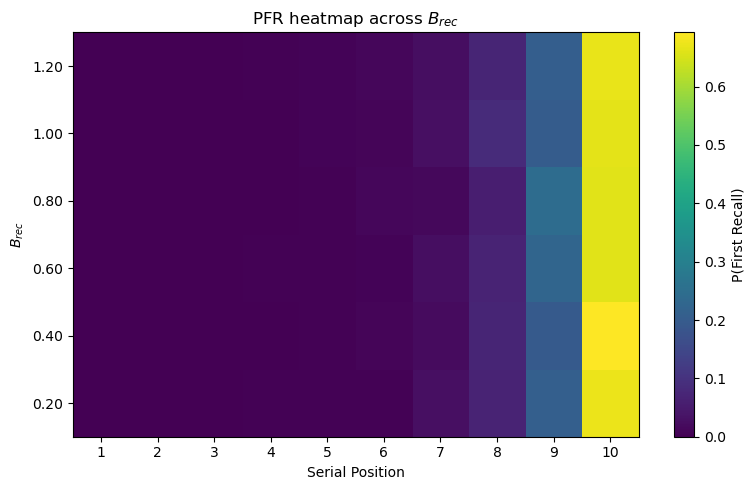

In [19]:
plot_pfr_heatmap(
    sweep_B_rec, B_rec_grid,
    param_name=r"$B_{rec}$",
    cmap_name="viridis",
    show_colorbar=True
)

#### SPC curve (probability recalled at each serial position, averaged over sims)

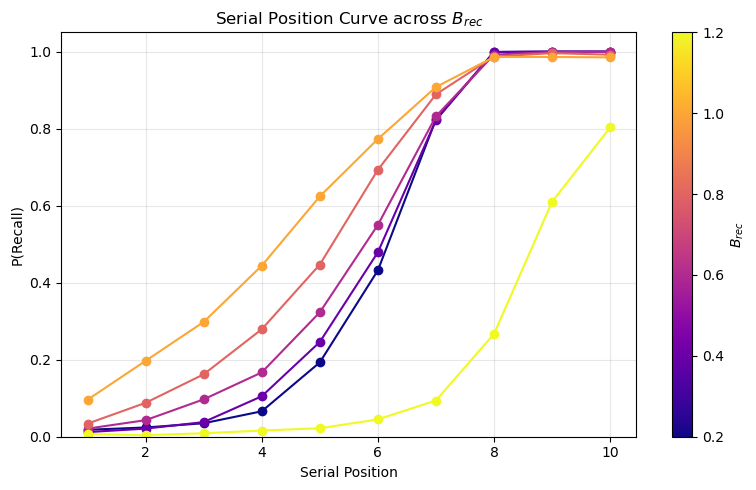

In [20]:
plot_spc_sweep(sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$", cmap_name="plasma")

####  lag-CRP (transition probabilities by lag, averaged)

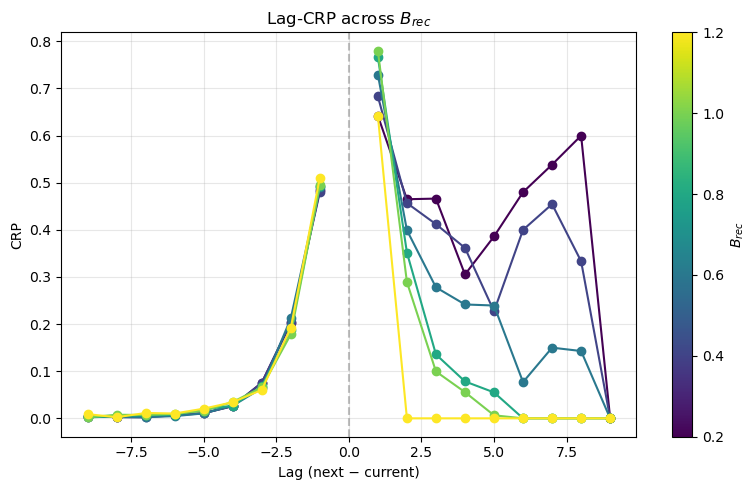

In [21]:
plot_lag_crp_sweep(sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$")

#### Cue Advantage

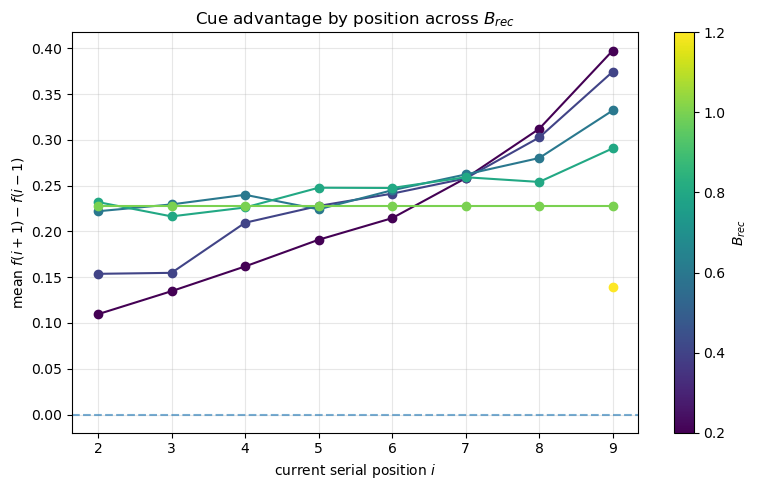

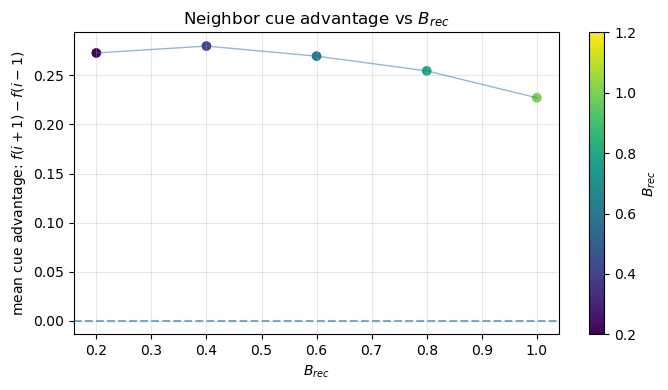

In [22]:
plot_cue_advantage_by_pos_sweep(
    sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$", cmap_name="viridis", show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_B_rec, B_rec_grid, param_name=r"$B_{rec}$", cmap_name="viridis", show_colorbar=True
)

---
### 2. Sweep strength of feature to context association

In [23]:
sweep_gamma_fc = sweep_one_param(
    param_name="gamma_fc",
    param_grid=gamma_fc_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

#### PFR curve (probability of first recall being each serial position, averaged over sims)

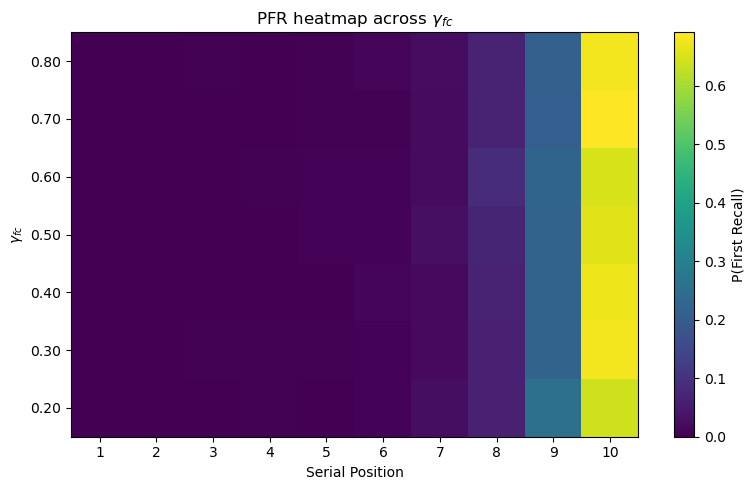

In [24]:
plot_pfr_heatmap(
    sweep_gamma_fc, gamma_fc_grid,
    param_name=r"$\gamma_{fc}$",
    cmap_name="viridis",
    show_colorbar=True
)

#### SPC curve (probability recalled at each serial position, averaged over sims)

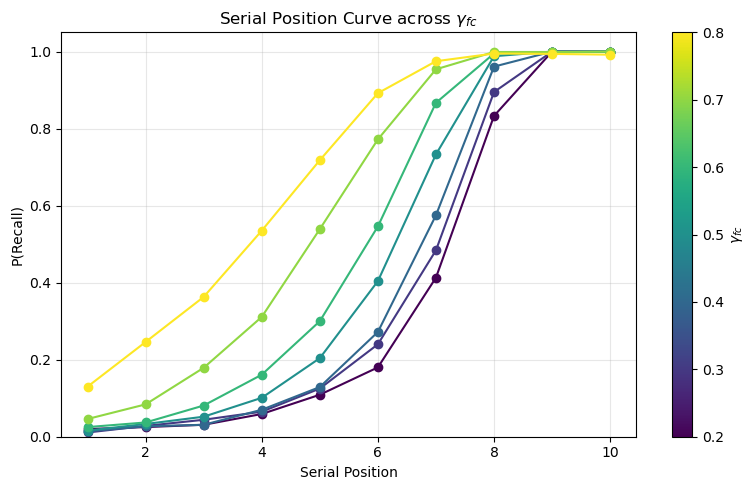

In [25]:
plot_spc_sweep(sweep_gamma_fc, gamma_fc_grid, param_name=r"$\gamma_{fc}$")

####  lag-CRP (transition probabilities by lag, averaged over sims)

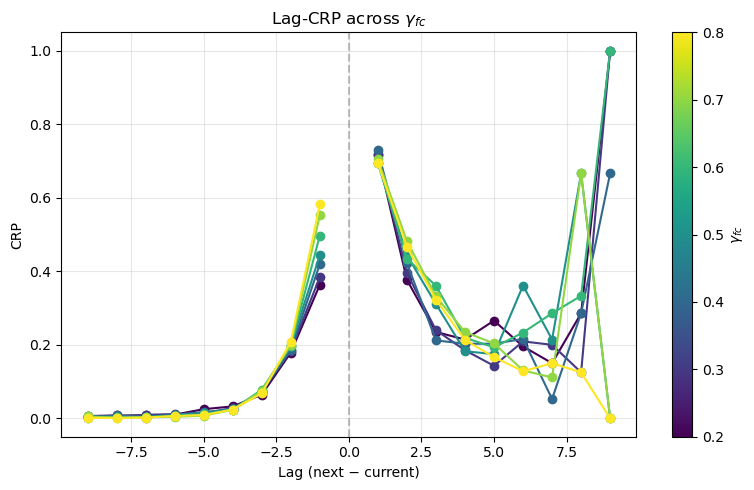

In [26]:
plot_lag_crp_sweep(sweep_gamma_fc, gamma_fc_grid, param_name=r"$\gamma_{fc}$")

#### Cue Advantage

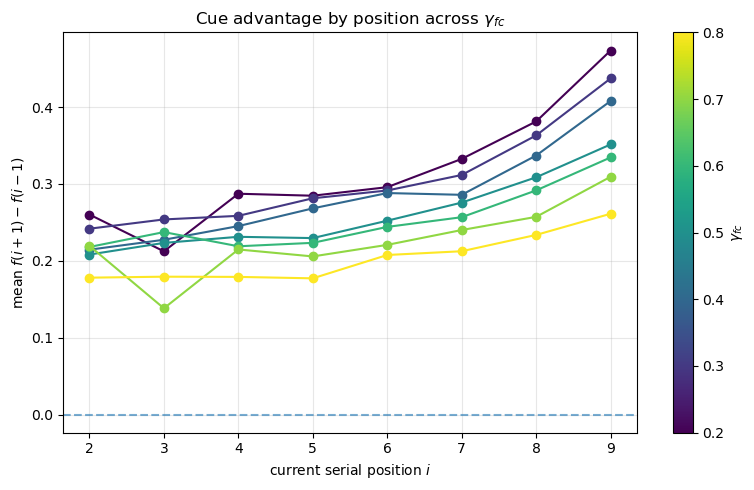

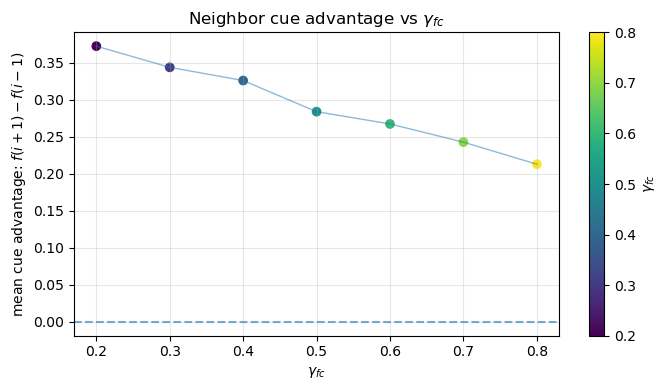

In [27]:
plot_cue_advantage_by_pos_sweep(
    sweep_gamma_fc, gamma_fc_grid,
    param_name=r"$\gamma_{fc}$",
    cmap_name="viridis",
    show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_gamma_fc, gamma_fc_grid,
    param_name=r"$\gamma_{fc}$",
    cmap_name="viridis",
    show_colorbar=True
)

---
### 3. Sweep noise level in the decision accumulator.

In [28]:
sweep_eta = sweep_one_param(
    param_name="eta",
    param_grid=eta_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

#### PFR curve (probability of first recall being each serial position, averaged)

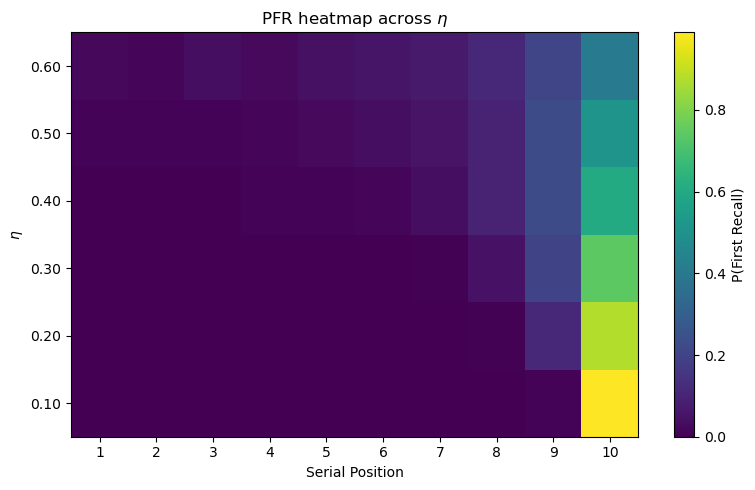

In [29]:
plot_pfr_heatmap(
    sweep_eta, eta_grid,
    param_name=r"$\eta$",
    cmap_name="viridis",
    show_colorbar=True
)

#### SPC curve (probability recalled at each serial position, averaged over sims)

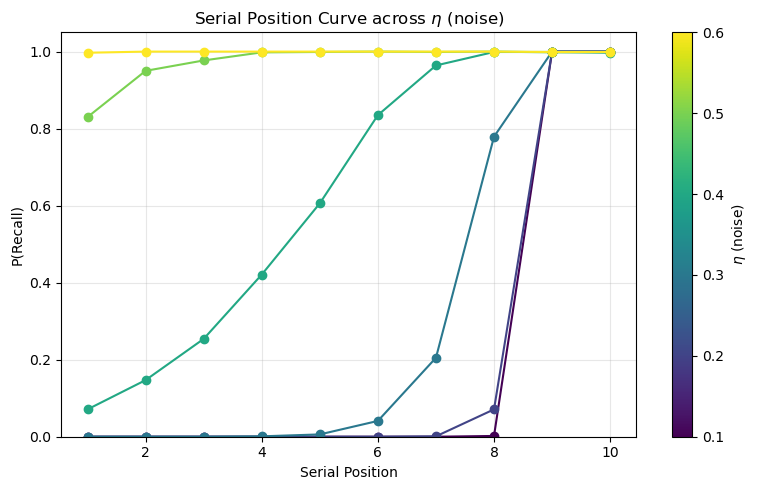

In [30]:
plot_spc_sweep(sweep_eta, eta_grid, param_name=r"$\eta$ (noise)")

####  lag-CRP (transition probabilities by lag, averaged)

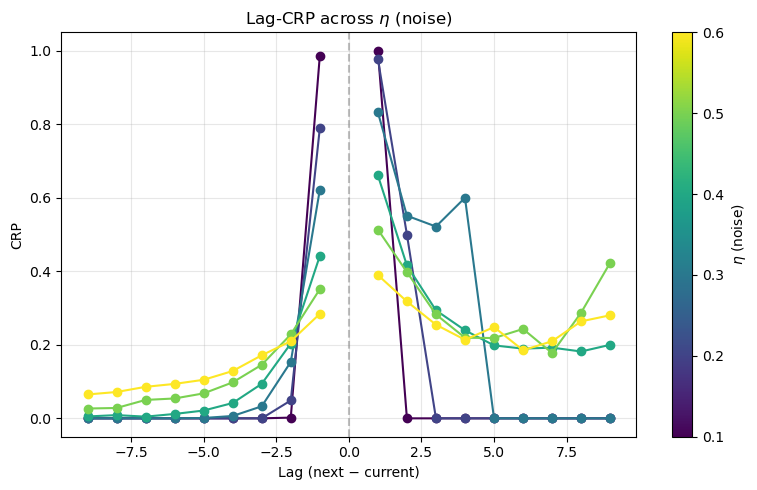

In [31]:
plot_lag_crp_sweep(sweep_eta, eta_grid, param_name=r"$\eta$ (noise)")

#### Cue Advantage

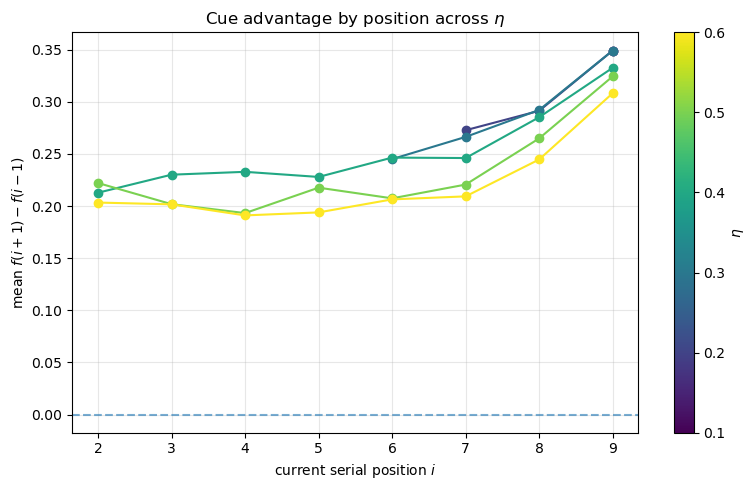

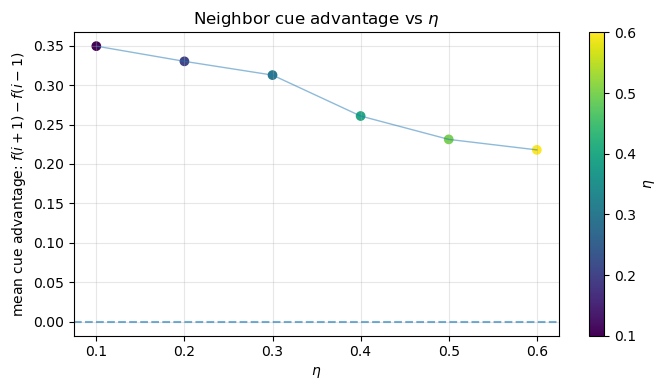

In [32]:
plot_cue_advantage_by_pos_sweep(
    sweep_eta, eta_grid,
    param_name=r"$\eta$",
    cmap_name="viridis",
    show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_eta, eta_grid,
    param_name=r"$\eta$",
    cmap_name="viridis",
    show_colorbar=True
)

---

### 4. Sweep scaled global encoding context drift.

In [33]:
sweep_B_enc_scale = sweep_one_param(
    param_name="B_encD_scale",
    param_grid=B_encD_scale_grid,
    base_params=BASE_PARAMS,
    n_sims=n_sims
)

#### PFR curve (probability of first recall being each serial position, averaged)

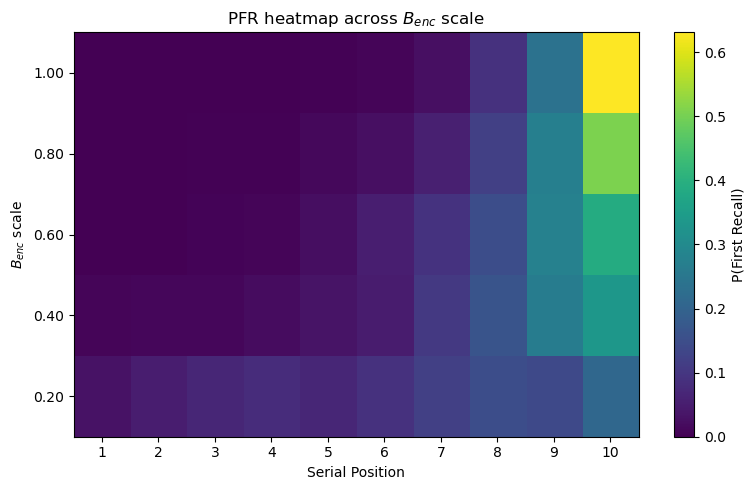

In [34]:
plot_pfr_heatmap(
    sweep_B_enc_scale, B_encD_scale_grid,
    param_name=r"$B_{enc}$ scale",
    cmap_name="viridis",
    show_colorbar=True
)

#### SPC curve (probability recalled at each serial position, averaged over sims)

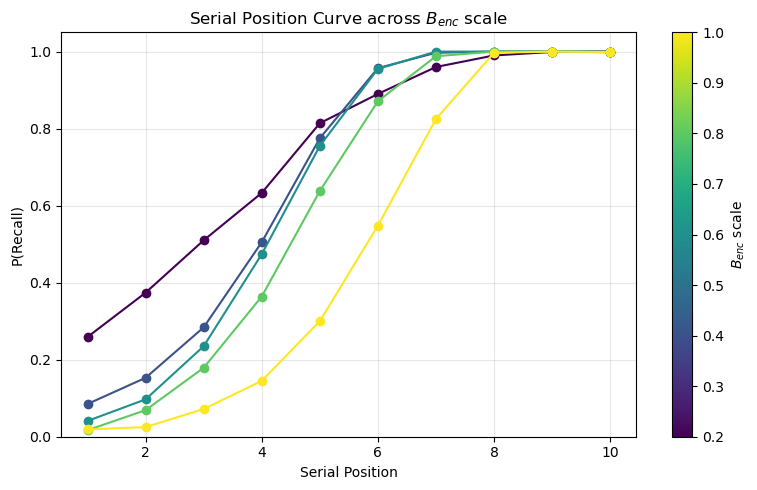

In [35]:
plot_spc_sweep(sweep_B_enc_scale, B_encD_scale_grid, param_name=r"$B_{enc}$ scale")

#### lag-CRP (transition probabilities by lag, averaged)

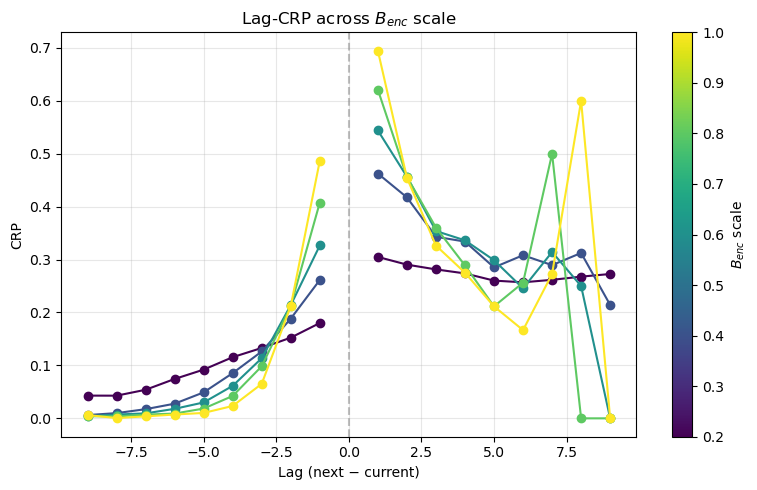

In [36]:
plot_lag_crp_sweep(sweep_B_enc_scale, B_encD_scale_grid, param_name=r"$B_{enc}$ scale")

#### Cue Advantage

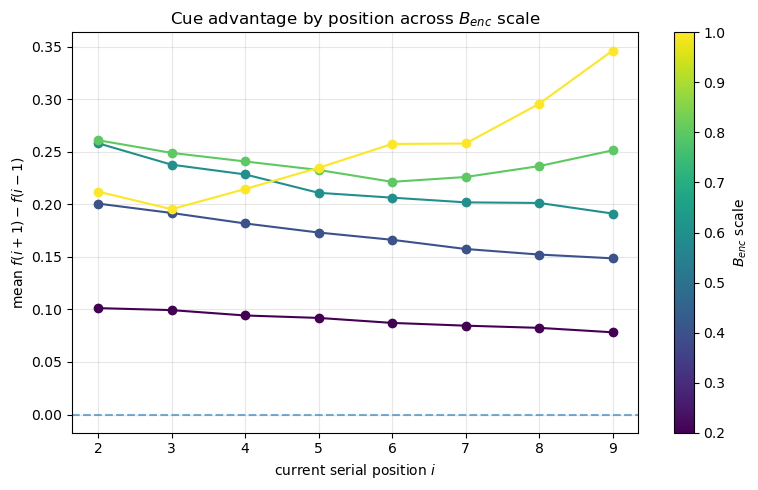

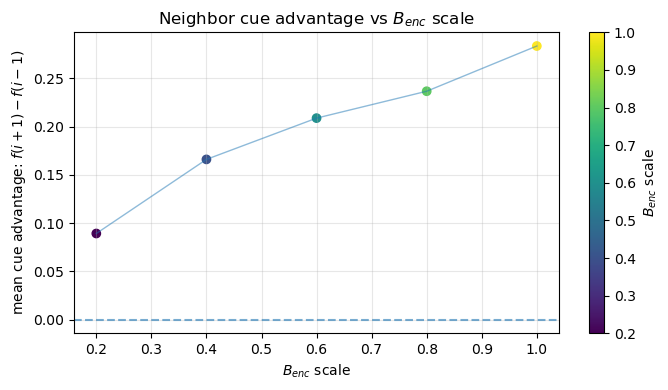

In [37]:
plot_cue_advantage_by_pos_sweep(
    sweep_B_enc_scale, B_encD_scale_grid,
    param_name=r"$B_{enc}$ scale",
    cmap_name="viridis",
    show_colorbar=True
)

plot_neighbor_advantage_vs_param(
    sweep_B_enc_scale, B_encD_scale_grid,
    param_name=r"$B_{enc}$ scale",
    cmap_name="viridis",
    show_colorbar=True
)

---
### To Sweep a New Parameter

```python
# 1. Add to BASE_PARAMS if needed
BASE_PARAMS["new_param"] = default_value

# 2. Add grid
new_param_grid = [val1, val2, val3]

# 3. Modify simulate_single_trial to accept it
def simulate_single_trial(B_rec, rng, new_param_val=None, ...):
    if new_param_val is None:
        new_param_val = BASE_PARAMS["new_param"]
    # Use new_param_val in simulation...

# 4. Run sweep
sweep_results = sweep_one_param("new_param", new_param_grid, BASE_PARAMS)
```